# Simulate data

In [ ]:
#! pip install arch

In [2]:
import itertools
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.api import SARIMAX
from arch.univariate import arch_model

In [3]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt

In [4]:
#path = 'C:/Users/Meier/Dropbox (Institut für Statistik)/Structural Breaks + DL/Simulation/Python Code/'

In [32]:
#setting = 'GARCH' # 'AR', 'ARIMA', 'GARCH'

In [16]:
#test_size = 0.1                                # proportion of test set
#l = 5000                                       # length of simulated sample
#tau = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7])  # break locations
#fac_beta = np.array([0.5,1,2])               # break size factor

In [36]:
#if setting == 'AR':
#    params = np.array([0.1,0.5,0.9,0.95,0.99]) # AR (phi)
#if setting == 'ARIMA':
#    params = [np.array([0.1,0.5,0.9,0.95,0.99]),np.array([0.3,-0.3])] # ARIMA (phi, theta)
#    print(list(itertools.product(params[0],params[1])))
#if setting == 'GARCH':
#    params = [np.array([0.1,0.8]), np.array([0.45,0.45]), np.array([0.8,0.1])] # GARCH (phi,theta)

In [56]:
def sim_data(setting, params, tau, fac_beta, test_size, l, path, lags=1, verbose=False):
    
    # zip parameter combinations if necessary
    if setting == 'ARIMA':
        params_list = list(itertools.product(params[0],params[1]))
    else:
        params_list = params
    
    # loop over all parameter combinations
    num_ref = 0
    num_tau = 0
    num_beta = 0
    for param in range(len(params_list)):  
        
        # simulate data withouth break
        if setting == 'AR':
            ar = np.array([1, -params_list[param]])
            ma = np.array([1])
            model = ArmaProcess(ar, ma)
            series = model.generate_sample(nsample=l+lags)
        if setting == 'ARIMA':
            zero_dat = np.zeros(l)
            model = SARIMAX(zero_dat, order=(1,1,1), initialization='diffuse')
            series = model.simulate([params_list[param][0],1,params_list[param][1]],l)
        if setting == 'GARCH':
            model = arch_model(None, mean='Zero', vol='Garch', p=1, q=1, dist="Normal")
            series = np.array(model.simulate([params_list[param][0],0,params_list[param][1]], l).data)
        num_ref += 1
        df = pd.DataFrame(series, columns=['Ref'])
        if verbose:
            plt.plot(series, color='green')
        
        # loop over break locations
        for t in tau:
            num_tau += 1
            
            # get break location
            break_loc = int((1-test_size)*t*l+lags) # location at specified proportion of training set (excluding the observations needed for lags)
            
            # save simulated series after breakpoint
            series2 = np.empty_like(series)
            series2[:] = np.nan
            series2[(break_loc-lags):] = series.copy()[(break_loc-lags):]
            colstr = 'Tau'+str(t)+'Ref'
            df2 = pd.DataFrame(series2, columns=[colstr])
            df = pd.concat([df,df2], axis=1)
            if verbose:
                plt.plot(series2, color='red')
            
            # loop over break sizes
            for fb in fac_beta:
                num_beta += 1
                
                # get break size
                beta = fb*np.std(series[lags:]) # determine the size of the break
            
                # add single mean break
                series_break = series.copy()
                series_break[lags:break_loc] += beta # add constant
            
                # save simulated series with break
                colstr = 'Tau'+str(t)+'Beta'+str(fb)
                df_break = pd.DataFrame(series_break, columns=[colstr])
                df = pd.concat([df,df_break], axis=1)
            if verbose:
                plt.plot(series_break, color='blue')
            
        # save all simulated series
        df.to_csv(path+'sim'+str(num_ref)+'.csv',na_rep='NA', index=False)
        if verbose:
            print('sim'+str(num_ref))
            plt.show()
            print(df)
    
    #return df
        

[-0.34019226 -0.77394117  0.05211961 ...  0.71990777  1.24569881
  0.38988778]
0      -0.340192
1      -0.773941
2       0.052120
3       0.496353
4      -0.113934
          ...   
4995    1.050758
4996   -0.377110
4997    0.719908
4998    1.245699
4999    0.389888
Name: Ref, Length: 5000, dtype: float64
sim1


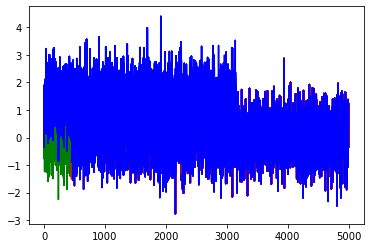

           Ref  Tau0.1Ref  Tau0.1Beta0.5  Tau0.1Beta1.0  Tau0.1Beta2.0  \
0    -0.340192        NaN      -0.340192      -0.340192      -0.340192   
1    -0.773941        NaN      -0.421900      -0.069858       0.634225   
2     0.052120        NaN       0.404161       0.756203       1.460286   
3     0.496353        NaN       0.848395       1.200436       1.904520   
4    -0.113934        NaN       0.238108       0.590149       1.294233   
...        ...        ...            ...            ...            ...   
4995  1.050758   1.050758       1.050758       1.050758       1.050758   
4996 -0.377110  -0.377110      -0.377110      -0.377110      -0.377110   
4997  0.719908   0.719908       0.719908       0.719908       0.719908   
4998  1.245699   1.245699       1.245699       1.245699       1.245699   
4999  0.389888   0.389888       0.389888       0.389888       0.389888   

      Tau0.2Ref  Tau0.2Beta0.5  Tau0.2Beta1.0  Tau0.2Beta2.0  Tau0.3Ref  ...  \
0           NaN      -0.340192 

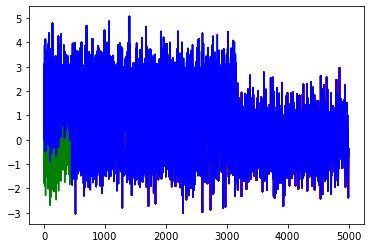

           Ref  Tau0.1Ref  Tau0.1Beta0.5  Tau0.1Beta1.0  Tau0.1Beta2.0  \
0     1.653177        NaN       1.653177       1.653177       1.653177   
1    -1.801149        NaN      -1.348504      -0.895860       0.009429   
2     0.649631        NaN       1.102275       1.554920       2.460208   
3     0.933784        NaN       1.386428       1.839073       2.744362   
4    -0.864067        NaN      -0.411423       0.041221       0.946510   
...        ...        ...            ...            ...            ...   
4995 -2.374739  -2.374739      -2.374739      -2.374739      -2.374739   
4996 -1.091621  -1.091621      -1.091621      -1.091621      -1.091621   
4997 -0.343025  -0.343025      -0.343025      -0.343025      -0.343025   
4998 -0.688355  -0.688355      -0.688355      -0.688355      -0.688355   
4999 -0.450746  -0.450746      -0.450746      -0.450746      -0.450746   

      Tau0.2Ref  Tau0.2Beta0.5  Tau0.2Beta1.0  Tau0.2Beta2.0  Tau0.3Ref  ...  \
0           NaN       1.653177 

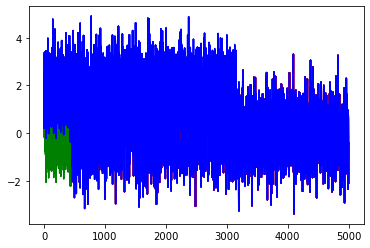

           Ref  Tau0.1Ref  Tau0.1Beta0.5  Tau0.1Beta1.0  Tau0.1Beta2.0  \
0     0.225478        NaN       0.225478       0.225478       0.225478   
1     0.692987        NaN       1.160983       1.628978       2.564970   
2    -0.182707        NaN       0.285289       0.753285       1.689276   
3     0.699810        NaN       1.167806       1.635801       2.571793   
4     0.351669        NaN       0.819664       1.287660       2.223652   
...        ...        ...            ...            ...            ...   
4995  0.607042   0.607042       0.607042       0.607042       0.607042   
4996 -0.558082  -0.558082      -0.558082      -0.558082      -0.558082   
4997 -2.113030  -2.113030      -2.113030      -2.113030      -2.113030   
4998 -0.381411  -0.381411      -0.381411      -0.381411      -0.381411   
4999 -0.991325  -0.991325      -0.991325      -0.991325      -0.991325   

      Tau0.2Ref  Tau0.2Beta0.5  Tau0.2Beta1.0  Tau0.2Beta2.0  Tau0.3Ref  ...  \
0           NaN       0.225478 

In [57]:
#df = sim_data(setting=setting, params=params, tau=tau, fac_beta=fac_beta, test_size=test_size, l=l, path=path+'Temp/', verbose=True,lags=1)
#sim_data(setting=setting, params=params, tau=tau, fac_beta=fac_beta, test_size=test_size, l=l, path=path+'Temp/', verbose=True,lags=1)